In [52]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("../science.mplstyle")

import os


import pickle

from helpers.data_transforms import inverse_transform, clean_data
from helpers.BDT import *
from helpers.physics_functions import *
from helpers.plotting import hist_all_features_array
from helpers.evaluation import assemble_banded_datasets

In [53]:
import yaml
with open("workflow.yaml", "r") as file:
    workflow = yaml.safe_load(file)
    
    
config_id = "CATHODE_8"

configs_path = f"configs/{config_id}.yml"
with open(configs_path, "r") as file:
    flow_configs = yaml.safe_load(file)
    


Train classifier to discriminate train samples from train data in the SR ONLY
By default, the test set data type is the same as `train_data_id`. There are 2 alternative test sets:
- If the train data is opp sign, one alt test set will be same sign (and vice versa)
- The test set used to construct the ROC curve, which is evaluated on a high-stats dataset

In [54]:
# load in the data

bands = ["SBL", "SR", "SBH"]
data_dict = {}

working_dir = "/global/cfs/cdirs/m3246/rmastand/dimuonAD/projects/logit_08_22/"
#working_dir = "/global/u1/r/rmastand/dimuonAD/projects/powerscaler_0813/"


flow_id = "single_3"
particle_type = "eta_none_3"

if "upsilon" in particle_type:
    particle_id = "upsilon"
elif "psi_prime" in particle_type:
    particle_id = "psi_prime"
elif "eta" in particle_type:
    particle_id = "eta"


project_id = "lowmass"


train_samples_id = ""
train_data_id = train_samples_id
if train_data_id == "": 
    alt_test_data_id = "_samesign"
    train_data_id_title = "_oppsign"
elif train_data_id == "_samesign": 
    alt_test_data_id = ""
    train_data_id_title = "_samesign"

ROC_test_data_1_id = ""

with open(f"{working_dir}/models/{project_id}_{particle_type}{train_samples_id}_nojet/{flow_id}/{config_id}/flow_samples", "rb") as infile: 
    train_samples_dict = pickle.load(infile)

# we actually want the "test band" here -- train is just for flow
with open(f"{working_dir}/processed_data/{project_id}_{particle_type}{train_data_id}_nojet_test_band_data", "rb") as infile: 
    test_data_dict = pickle.load(infile)

with open(f"{working_dir}/processed_data/{project_id}_{particle_type}{alt_test_data_id}_nojet_test_band_data", "rb") as infile: 
    alt_test_data_dict = pickle.load(infile)
    
# ROC set 1 is evaluated on the FULL high stats dataset
#with open(f"{working_dir}/processed_data/{project_id}_{particle_type}{ROC_test_data_id}_nojet_train_band_data", "rb") as infile: 
with open(f"{working_dir}/processed_data/{project_id}_{particle_type}_nojet_train_band_data", "rb") as infile: 
    ROC_test_data_1_dict = pickle.load(infile)

# ROC set 2 is evaluated on a higher stats version of the flow samples

    
print(f"Loading classifier train samples from {project_id}_{particle_type}{train_samples_id}")
print(f"Loading classifier train data from {project_id}_{particle_type}{train_data_id}")
print(f"Loading alternative test data from {project_id}_{particle_type}{alt_test_data_id}")
print(f"Loading ROC test data from {project_id}_{particle_type}{ROC_test_data_1_id}")
print()

with open(f"{working_dir}/models/{project_id}_{particle_type}{train_samples_id}_nojet/{flow_id}/{config_id}/configs.txt", "rb") as infile: 
    configs = infile.readlines()[0].decode("utf-8")
    feature_set = [x.strip() for x in configs.split("'")][1::2]

print(feature_set)



Loading classifier train samples from lowmass_eta_none_3
Loading classifier train data from lowmass_eta_none_3
Loading alternative test data from lowmass_eta_none_3_samesign
Loading ROC test data from lowmass_eta_none_3

['mu0_ip3d', 'mu1_ip3d', 'mu0_jetiso', 'mu1_jetiso', 'dimu_mass']


In [55]:
# Assemble the test sets -- consists of both SB and SR


# test set events: not used during flow training
banded_test_data = assemble_banded_datasets(test_data_dict, feature_set, bands)

# alt test set events
banded_alt_test_data = assemble_banded_datasets(alt_test_data_dict, feature_set, bands)

# ROC test set events
banded_ROC_test_data = assemble_banded_datasets(ROC_test_data_1_dict, feature_set, bands)

num_test_events = banded_test_data["SR"].shape[0]+banded_test_data["SBL"].shape[0]+banded_test_data["SBH"].shape[0]
print(f"Total number of default test events: {num_test_events}.")
num_test_events = banded_alt_test_data["SR"].shape[0]+banded_alt_test_data["SBL"].shape[0]+banded_alt_test_data["SBH"].shape[0]
print(f"Total number of alt test events: {num_test_events}.")
num_test_events = banded_ROC_test_data["SR"].shape[0]+banded_ROC_test_data["SBL"].shape[0]+banded_ROC_test_data["SBH"].shape[0]
print(f"Total number of ROC test events: {num_test_events}.")

SR_min_rescaled = np.min(banded_test_data["SR"][:,-1])
SR_max_rescaled = np.max(banded_test_data["SR"][:,-1])


Total number of default test events: 149998.
Total number of alt test events: 1999.
Total number of ROC test events: 404311.


Training in SR with id: .


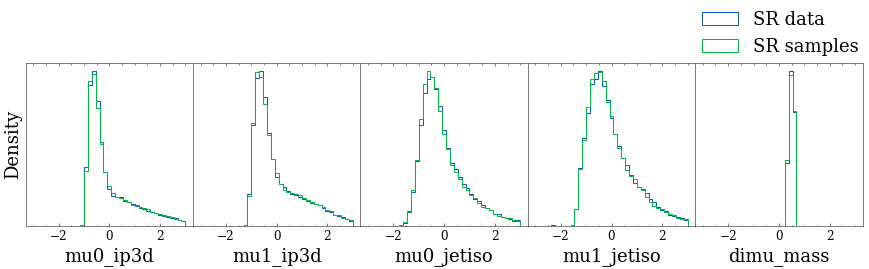

In [56]:
# plot things in the SR

print(f"Training in SR with id: {train_samples_id}.")
hist_all_features_array([train_samples_dict["SR"], train_samples_dict["SR_samples"]], ["SR data", "SR samples"], 
                        feature_set, plot_bound = 3, yscale_log = False)



## Train the BDTs

Train to discriminate (flow samples in SR) from (test data in SR)

In [59]:
bdt_hyperparams_dict = {
    "n_estimators": 300, # number of boosting stages
    "max_depth":3, # max depth of individual regression estimators; related to complexity
    "learning_rate":0.1,  # stop training BDT is validation loss doesn't improve after this many rounds
    "subsample":0.7,   # fraction of samples to be used for fitting the individual base learners
    "early_stopping_rounds":10,
    "n_ensemble": 20
    
}

Fold 0:
X train shape: (38255, 4), Y train shape: (38255, 1), w train shape: (38255, 1).
X val shape: (12751, 4), Y val shape: (12751, 1), w val shape: (12751, 1).
X test shape: (30001, 4).
   Network number: 0
   Network number: 1
   Network number: 2
   Network number: 3
   Network number: 4
   Network number: 5
   Network number: 6
   Network number: 7
   Network number: 8
   Network number: 9
   Network number: 10
   Network number: 11
   Network number: 12
   Network number: 13
   Network number: 14
   Network number: 15
   Network number: 16
   Network number: 17
   Network number: 18
   Network number: 19


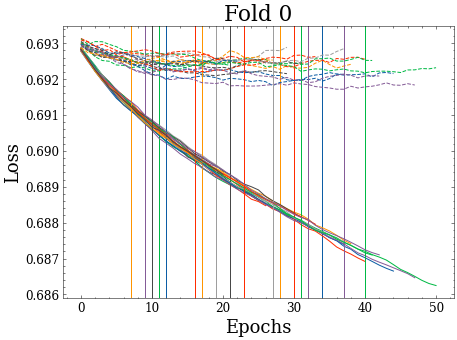

Fold 1:
X train shape: (38254, 4), Y train shape: (38254, 1), w train shape: (38254, 1).
X val shape: (12753, 4), Y val shape: (12753, 1), w val shape: (12753, 1).
X test shape: (30000, 4).
   Network number: 0
   Network number: 1
   Network number: 2
   Network number: 3
   Network number: 4
   Network number: 5
   Network number: 6
   Network number: 7
   Network number: 8
   Network number: 9
   Network number: 10
   Network number: 11
   Network number: 12
   Network number: 13
   Network number: 14
   Network number: 15
   Network number: 16
   Network number: 17
   Network number: 18
   Network number: 19


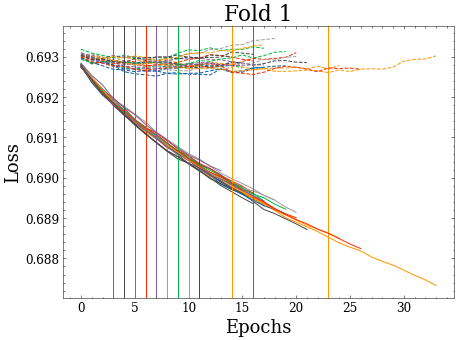

Fold 2:
X train shape: (38255, 4), Y train shape: (38255, 1), w train shape: (38255, 1).
X val shape: (12752, 4), Y val shape: (12752, 1), w val shape: (12752, 1).
X test shape: (29999, 4).
   Network number: 0
   Network number: 1
   Network number: 2
   Network number: 3
   Network number: 4
   Network number: 5
   Network number: 6
   Network number: 7
   Network number: 8
   Network number: 9
   Network number: 10
   Network number: 11
   Network number: 12
   Network number: 13
   Network number: 14
   Network number: 15
   Network number: 16
   Network number: 17
   Network number: 18
   Network number: 19


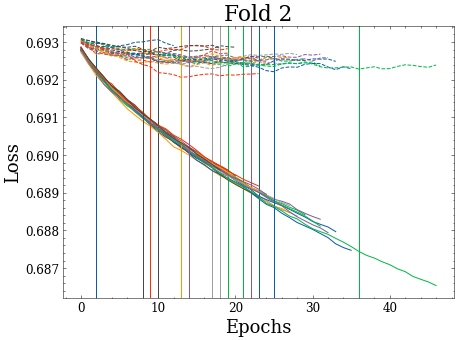

Fold 3:
X train shape: (38256, 4), Y train shape: (38256, 1), w train shape: (38256, 1).
X val shape: (12752, 4), Y val shape: (12752, 1), w val shape: (12752, 1).
X test shape: (29999, 4).
   Network number: 0
   Network number: 1
   Network number: 2
   Network number: 3
   Network number: 4
   Network number: 5
   Network number: 6
   Network number: 7
   Network number: 8
   Network number: 9
   Network number: 10
   Network number: 11
   Network number: 12
   Network number: 13
   Network number: 14
   Network number: 15
   Network number: 16
   Network number: 17
   Network number: 18
   Network number: 19


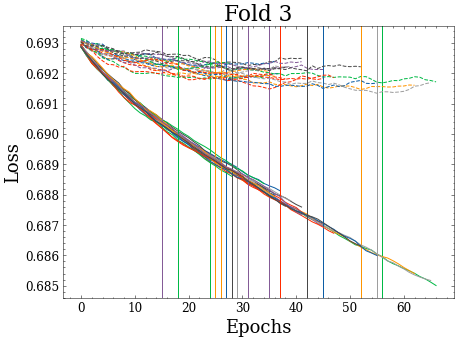

Fold 4:
X train shape: (38257, 4), Y train shape: (38257, 1), w train shape: (38257, 1).
X val shape: (12751, 4), Y val shape: (12751, 1), w val shape: (12751, 1).
X test shape: (29999, 4).
   Network number: 0
   Network number: 1
   Network number: 2
   Network number: 3
   Network number: 4
   Network number: 5
   Network number: 6
   Network number: 7
   Network number: 8
   Network number: 9
   Network number: 10
   Network number: 11
   Network number: 12
   Network number: 13
   Network number: 14
   Network number: 15
   Network number: 16
   Network number: 17
   Network number: 18
   Network number: 19


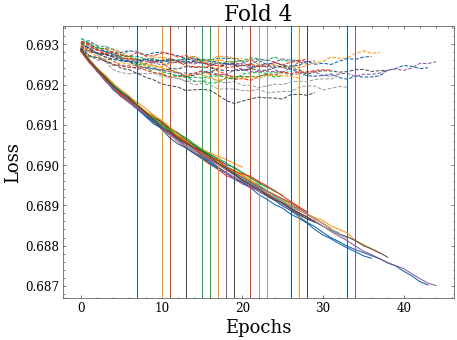

In [60]:
# Train a classifier to discriminate SR samples from SR data

n_folds = 5


alt_test_sets_data = {
    "FPR_validation":train_samples_dict["SR_samples_validation"],
                      "alt":np.vstack([banded_alt_test_data["SR"],banded_alt_test_data["SBL"],banded_alt_test_data["SBH"]]),
                      "ROC_data":np.vstack([banded_ROC_test_data["SR"],banded_ROC_test_data["SBL"],banded_ROC_test_data["SBH"]]),
                     "ROC_samples":np.vstack([train_samples_dict["SR_samples_ROC"],train_samples_dict["SBL_samples_ROC"],train_samples_dict["SBH_samples_ROC"]]),
}



test_data_splits, scores_splits, alt_data_splits, alt_scores_splits = run_BDT_bump_hunt(clean_data(train_samples_dict["SR_samples"]), 
                                        clean_data(banded_test_data["SR"]), clean_data(np.vstack([banded_test_data["SBL"],banded_test_data["SBH"]])), 
                                            n_folds, bdt_hyperparams_dict,
                                            alt_test_sets_data=alt_test_sets_data,
                                                                     visualize=True)



## Analysis


### True bump hunt

- Define a polynomial form for the background fit
- For each cut on the classifier score:
  - Fit the background on the cut SB data
  - Estimate N_bkg
  - Calculate S/B, S/sqrt(B)



In [65]:
with open(f"{working_dir}/processed_data/mass_scaler_{particle_type}", "rb") as ifile:
    scaler = pickle.load(ifile)
    
fpr_thresholds = [1, 0.5, 0.25, 0.1, 0.005, 0.002]
score_cutoffs = {i:{threshold
                    :0 for threshold in fpr_thresholds} for i in range(n_folds)}


for i_fold in range(n_folds):
    for threshold in fpr_thresholds:
                
            loc_scores_sorted = np.sort(1.0-np.mean(alt_scores_splits["FPR_validation"][i_fold], axis = 1))
            loc_score_cutoff = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
            
            score_cutoffs[i_fold][threshold] = loc_score_cutoff


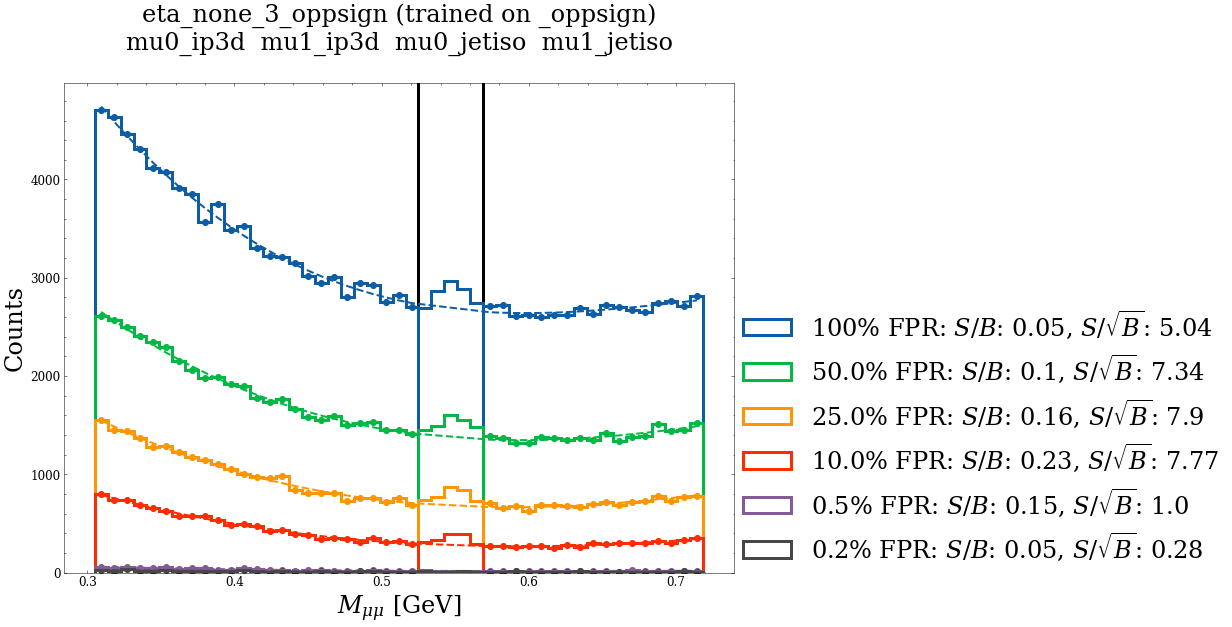

In [66]:



SB_left = float(workflow[particle_id]["SB_left"])
SR_left = float(workflow[particle_id]["SR_left"])
SR_right = float(workflow[particle_id]["SR_right"])
SB_right = float(workflow[particle_id]["SB_right"])

    

fit_type = "cubic"

plot_histograms_with_fits(fpr_thresholds, test_data_splits, scores_splits, score_cutoffs, scaler, fit_type,
                          f"{particle_type}{train_data_id_title} (trained on {train_data_id_title})\n"+"  ".join(feature_set[:-1])+"\n", 
                          SB_left, SR_left, SR_right, SB_right)




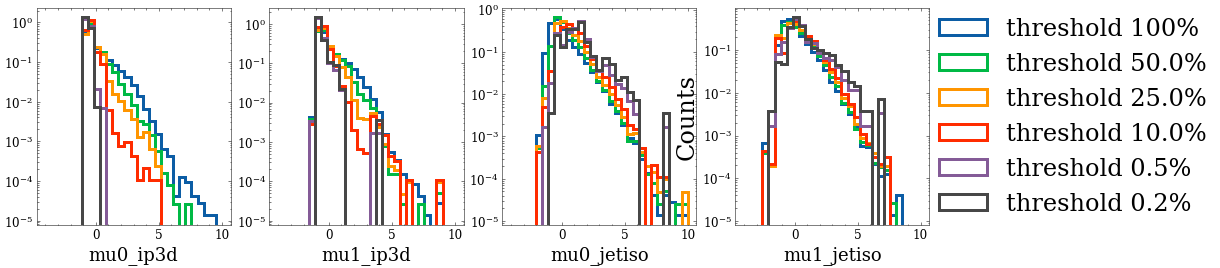

In [79]:

def plot_feature_hists_with_cut(fpr_thresholds, data_dict_by_fold, scores_dict_by_fold, score_cutoffs_by_fold, n_folds= 5, take_score_avg=True):
    
    n_features = data_dict_by_fold[0].shape[1]-1


    fig, ax = plt.subplots(1, 4, figsize = (4*n_features, 4))
    
    
    for t, threshold in enumerate(fpr_thresholds):
        
        for feat_i in range(n_features):

            filtered_features = []

            for i_fold in range(n_folds):
                if take_score_avg:
                    loc_scores = np.mean(scores_dict_by_fold[i_fold], axis = 1)
                else:
                    loc_scores = scores_dict_by_fold[i_fold]
                pass_scores = loc_scores >= score_cutoffs_by_fold[i_fold][threshold]
                
                
                
                filtered_features.append(data_dict_by_fold[i_fold][:,feat_i].reshape(-1,1)[pass_scores])

            filtered_features = np.concatenate(filtered_features)
            
            ax[feat_i].hist(filtered_features, bins = np.linspace(-4, 10, 30), density = True, label = f"threshold {100*threshold}%", histtype = "step", lw = 3, color = f"C{t}")
            ax[feat_i].set_xlabel(feature_set[feat_i])
            ax[feat_i].set_yscale("log")

       
    plt.legend(loc = (1, 0), fontsize = 24)

    plt.ylabel("Counts", fontsize = 24)
    

plot_feature_hists_with_cut(fpr_thresholds, test_data_splits, scores_splits, score_cutoffs)



/global/u1/r/rmastand/dimuonAD/helpers/physics_functions.py:95: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)
/global/u1/r/rmastand/dimuonAD/helpers/physics_functions.py:95: RuntimeWarning: divide by zero encountered in divide
  return np.sum((y_fit - y_true)**2/y_true)


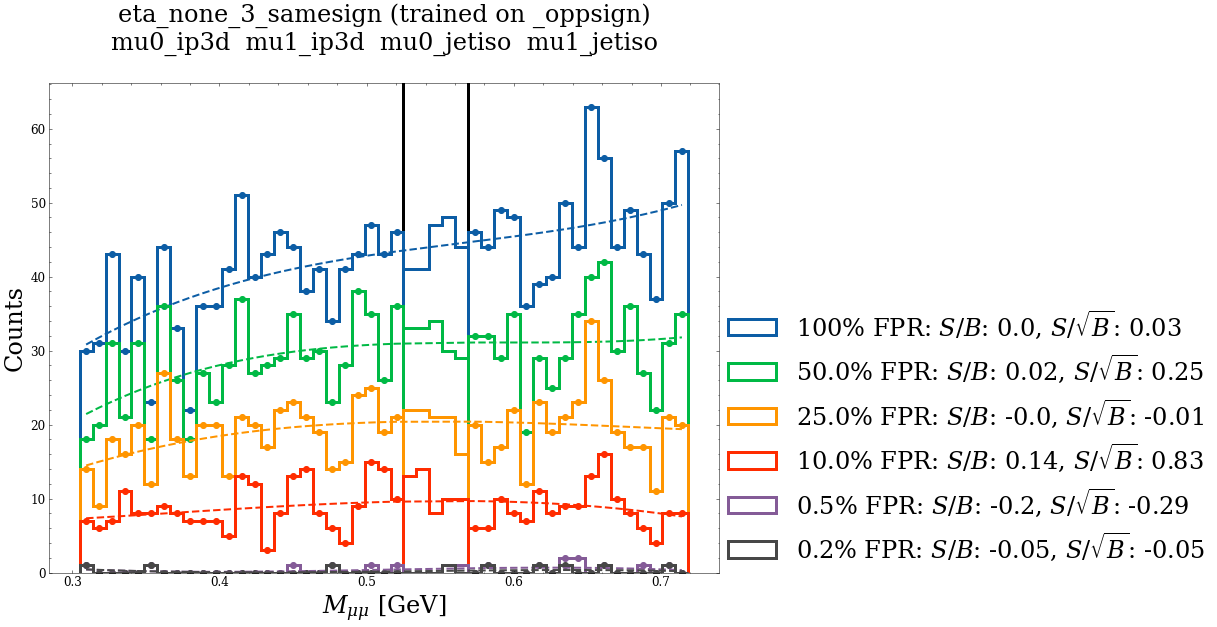

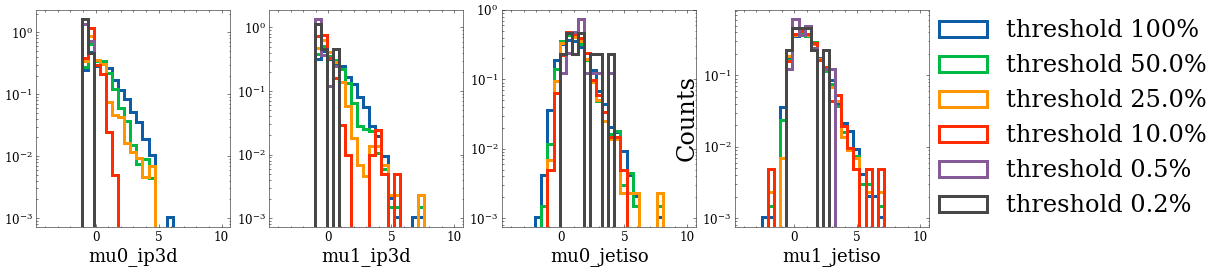

In [77]:


plot_histograms_with_fits(fpr_thresholds, alt_data_splits["alt"], alt_scores_splits["alt"], score_cutoffs, scaler, fit_type,
                          f"{particle_type}{alt_test_data_id} (trained on {train_data_id_title})\n"+"  ".join(feature_set[:-1])+"\n",
                         SB_left, SR_left, SR_right, SB_right)


plot_feature_hists_with_cut(fpr_thresholds, alt_data_splits["alt"], alt_scores_splits["alt"], score_cutoffs)



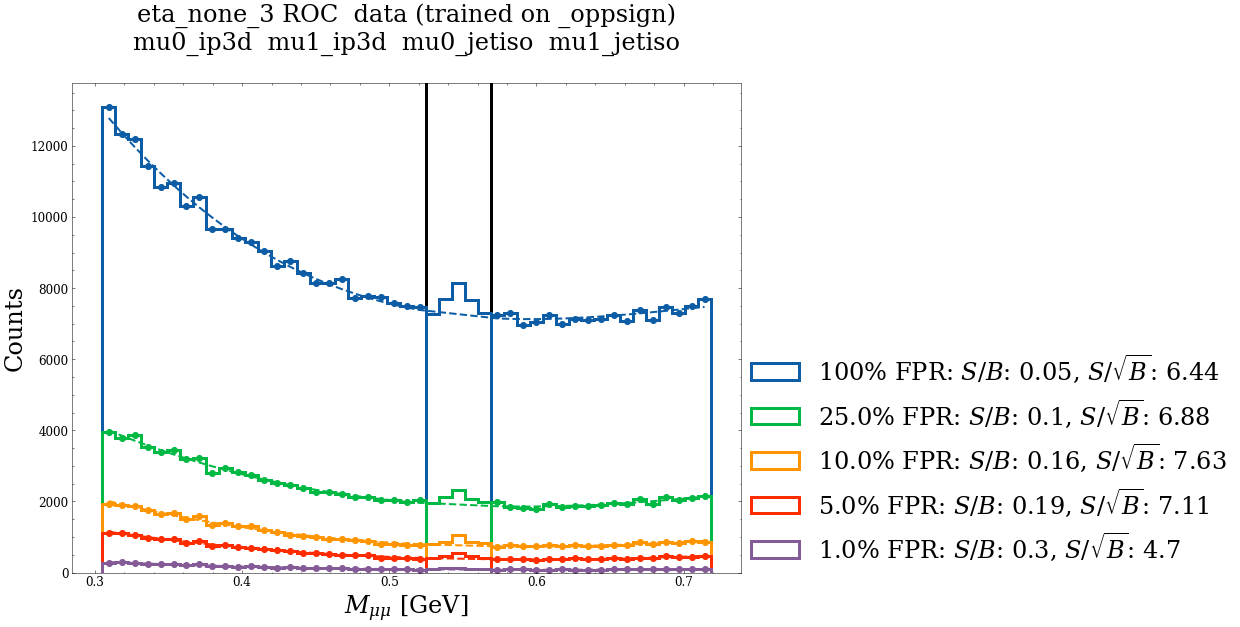

In [12]:


plot_histograms_with_fits(fpr_thresholds, alt_data_splits["ROC_data"], alt_scores_splits["ROC_data"], score_cutoffs, scaler, fit_type,
                          f"{particle_type} ROC {ROC_test_data_1_id} data (trained on {train_data_id_title})\n"+"  ".join(feature_set[:-1])+"\n",
                         SB_left, SR_left, SR_right, SB_right)


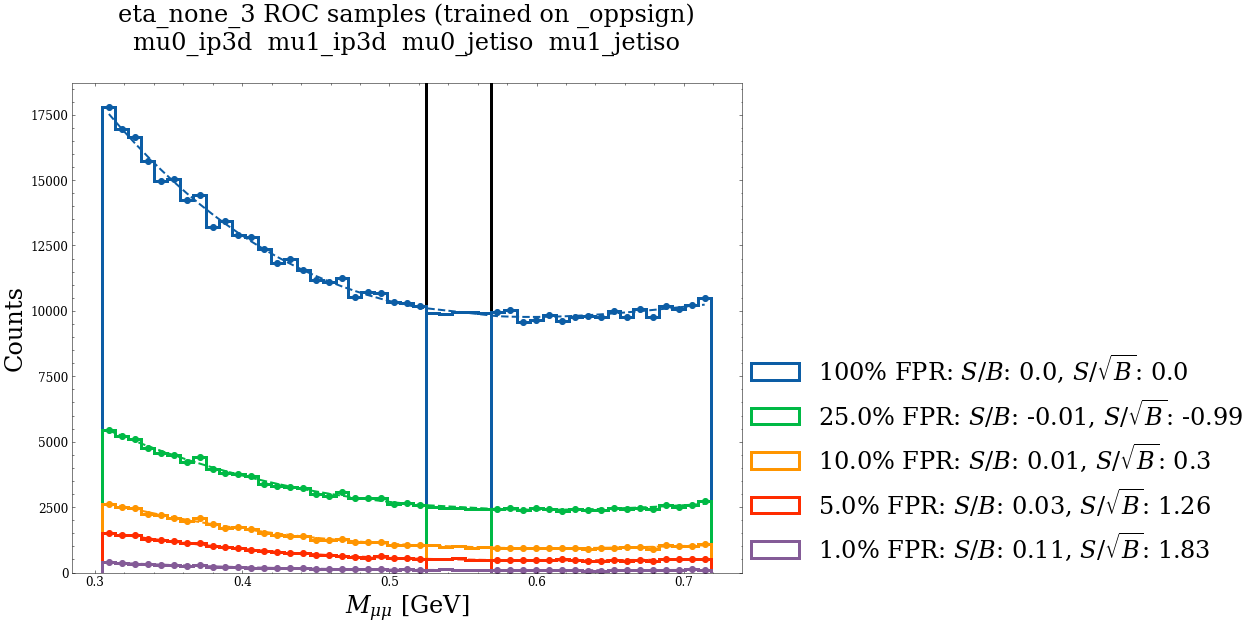

In [13]:


plot_histograms_with_fits(fpr_thresholds, alt_data_splits["ROC_samples"], alt_scores_splits["ROC_samples"], score_cutoffs, scaler, fit_type,
                          f"{particle_type} ROC samples (trained on {train_data_id_title})\n"+"  ".join(feature_set[:-1])+"\n",
                         SB_left, SR_left, SR_right, SB_right)


## ROC curve


### True classifier uncertainty

In [17]:

    


n_to_ensemble = bdt_hyperparams_dict["n_ensemble"]

fit_type = "cubic"
if fit_type == "cubic": fit_function = bkg_fit_cubic
elif fit_type == "quintic": fit_function = bkg_fit_quintic
elif fit_type == "ratio": fit_function = bkg_fit_ratio



fpr_thresholds = np.logspace(0, -3, 20)
#fpr_thresholds = np.linspace(1, 0 , 50)

plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right)


# first determine score cutoffs
score_cutoffs = {i:{threshold:np.zeros((n_to_ensemble,1)) for threshold in fpr_thresholds} for i in range(n_folds)}

for t, threshold in enumerate(fpr_thresholds):
    for i_fold in range(n_folds):
        for i_classifier in range(n_to_ensemble):
            loc_scores_sorted = np.sort(1.0-alt_scores_splits["FPR_validation"][i_fold][:,i_classifier])
            score_cutoffs[i_fold][threshold][i_classifier] = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
        
        
        

def get_median_percentiles(x_array):
    
    
    x_median = np.median(x_array, axis = 1)
    x_lower = np.percentile(x_array, 16, axis = 1)
    x_upper = np.percentile(x_array, 84, axis = 1)

    return x_median, x_lower, x_upper



        
        
def get_classifier_metrics_high_stats(data_split_by_fold, scores_split_by_fold, score_cutoffs_split_by_fold):
    

    S_yield, B_yield = np.empty((fpr_thresholds.shape[0], n_to_ensemble)), np.empty((fpr_thresholds.shape[0], n_to_ensemble))

    for bs in range(n_to_ensemble):

        print(f"On classifier index {bs}...")

        for t, threshold in enumerate(fpr_thresholds):

            filtered_masses_bs = []

            for i_fold in range(n_folds):

                loc_true_masses_bs = scaler.inverse_transform(np.array(data_split_by_fold[i_fold][:,-1]).reshape(-1,1))
                loc_scores_bs = scores_split_by_fold[i_fold][:,bs]
                # filter top event based on score cutoff
                loc_filtered_masses_bs, _, _, _ = select_top_events_fold(loc_true_masses_bs, loc_scores_bs, score_cutoffs_split_by_fold[i_fold][threshold][bs], plot_bins_left, plot_bins_right, plot_bins_SR)
                filtered_masses_bs.append(loc_filtered_masses_bs)

            filtered_masses_bs = np.concatenate(filtered_masses_bs)

            # get the fit function to SB background
            popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses_bs, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_all)
            num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses_bs, fit_function, plot_bins_SR, SR_left, SR_right, popt)

            S_yield[t, bs] = num_S_expected_in_SR
            B_yield[t, bs] = num_B_expected_in_SR
            
       
            
    
    # calculate summary stats
    TPR = S_yield/S_yield[0,:]
    FPR = B_yield/B_yield[0,:]

    ROC = 1.0/FPR

    SIC = TPR/np.sqrt(FPR)



    return TPR, FPR, ROC, SIC


        
        


On classifier index 0...
On classifier index 1...
On classifier index 2...
On classifier index 3...
On classifier index 4...


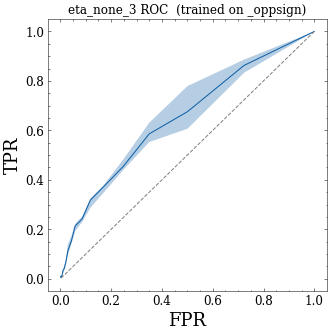

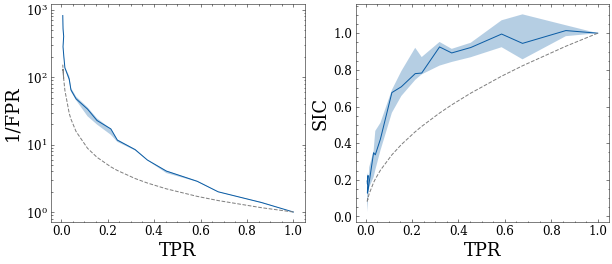

In [18]:
TPR, FPR, ROC, SIC = get_classifier_metrics_high_stats(alt_data_splits["ROC_data"], alt_scores_splits["ROC_data"], score_cutoffs)



     
TPR_median, TPR_lower, TPR_upper = get_median_percentiles(TPR)
FPR_median, FPR_lower, FPR_upper = get_median_percentiles(FPR)
ROC_median, ROC_lower, ROC_upper = get_median_percentiles(ROC)
SIC_median, SIC_lower, SIC_upper = get_median_percentiles(SIC)

plt.figure(figsize = (5, 5))
plt.plot(FPR_median, TPR_median)
plt.fill_between(FPR_median, TPR_lower, TPR_upper, alpha = 0.3 )
plt.plot(FPR_median, FPR_median, linestyle = "dashed", color = "grey")
plt.xlabel("FPR")
plt.ylabel("TPR")


plt.title(f"{particle_type} ROC {ROC_test_data_1_id} (trained on {train_data_id_title})")
fig, ax = plt.subplots(1, 2, figsize = (10, 4))


ax[0].plot(TPR_median, ROC_median)
ax[0].fill_between(TPR_median, ROC_lower, ROC_upper, alpha = 0.3 )
ax[0].plot(TPR_median, 1.0/TPR_median, linestyle = "dashed", color = "grey")
ax[0].set_xlabel("TPR")
ax[0].set_ylabel("1/FPR")
ax[0].set_yscale("log")

ax[1].plot(TPR_median, SIC_median)
ax[1].fill_between(TPR_median, SIC_lower, SIC_upper, alpha = 0.3 )
ax[1].plot(TPR_median, TPR_median/np.sqrt(TPR_median), linestyle = "dashed", color = "grey")
ax[1].set_xlabel("TPR")
ax[1].set_ylabel("SIC")


plt.show()


On classifier index 0...
On classifier index 1...
On classifier index 2...
On classifier index 3...
On classifier index 4...


/tmp/ipykernel_1938799/609895672.py:29: RuntimeWarning: invalid value encountered in sqrt
  ax[1].plot(TPR_median, TPR_median/np.sqrt(TPR_median), linestyle = "dashed", color = "grey")


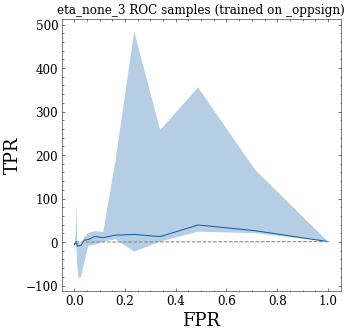

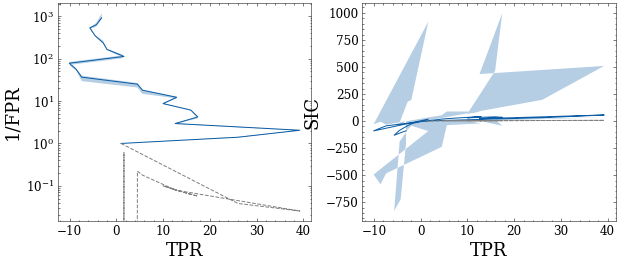

In [19]:

TPR, FPR, ROC, SIC = get_classifier_metrics_high_stats(alt_data_splits["ROC_samples"], alt_scores_splits["ROC_samples"], score_cutoffs)

TPR_median, TPR_lower, TPR_upper = get_median_percentiles(TPR)
FPR_median, FPR_lower, FPR_upper = get_median_percentiles(FPR)
ROC_median, ROC_lower, ROC_upper = get_median_percentiles(ROC)
SIC_median, SIC_lower, SIC_upper = get_median_percentiles(SIC)

plt.figure(figsize = (5, 5))
plt.plot(FPR_median, TPR_median)
plt.fill_between(FPR_median, TPR_lower, TPR_upper, alpha = 0.3 )
plt.plot(FPR_median, FPR_median, linestyle = "dashed", color = "grey")
plt.xlabel("FPR")
plt.ylabel("TPR")


plt.title(f"{particle_type} ROC samples (trained on {train_data_id_title})")
fig, ax = plt.subplots(1, 2, figsize = (10, 4))


ax[0].plot(TPR_median, ROC_median)
ax[0].fill_between(TPR_median, ROC_lower, ROC_upper, alpha = 0.3 )
ax[0].plot(TPR_median, 1.0/TPR_median, linestyle = "dashed", color = "grey")
ax[0].set_xlabel("TPR")
ax[0].set_ylabel("1/FPR")
ax[0].set_yscale("log")

ax[1].plot(TPR_median, SIC_median)
ax[1].fill_between(TPR_median, SIC_lower, SIC_upper, alpha = 0.3 )
ax[1].plot(TPR_median, TPR_median/np.sqrt(TPR_median), linestyle = "dashed", color = "grey")
ax[1].set_xlabel("TPR")
ax[1].set_ylabel("SIC")


plt.show()
   